In [1]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [37]:
ind="stashcp-2016.7"
#new data
myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1468271019126,
                  "lte": 1468273921657,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

#undirected
myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1468002935971,
                  "lte": 1468005422807,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [38]:
page= es.search(index=ind, body=myquery1, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
#del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
#del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(list(df.columns.values))
print(df.head(1))

992
['cache', 'download_time', 'end1', 'end2', 'filename', 'host', 'sitename', 'start1', 'start2', 'start3', 'status', 'timestamp', 'tries', 'xrdexit1', 'xrdexit2', 'xrdexit3', 'begin']
                        cache download_time           end1 end2  \
0  root://data.ci-connect.net         11846  1468271051339    0   

                            filename                        host  \
0  user/taburaad/public/2gb_file.tar  root://data.ci-connect.net   

       sitename         start1 start2 start3   status      timestamp tries  \
0  MWT2_CE_UIUC  1468271039493      0      0  Success  1468271051000     1   

  xrdexit1 xrdexit2 xrdexit3          begin  
0        0       -1       -1  1468271039154  


In [39]:
begin=int(df['begin'].iloc[1])//1000
print(df['begin'].iloc[1])
print(begin)
print (datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S'))
#print (datetime.datetime.fromtimestamp(df['begin'].iloc[1]).strftime('%Y-%m-%d %H:%M:%S'))





1468271039184
1468271039
2016-07-11 16:03:59


In [40]:
length=df.shape[0]

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    start1=int(df['start1'].iloc[i])//1000
    end1=int(df['end1'].iloc[i])//1000
    start2=int(df['start2'].iloc[i])//1000
    end2=int(df['end2'].iloc[i])//1000
    start3=int(df['start3'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    df['start1'].iloc[i]=datetime.datetime.fromtimestamp(start1).strftime('%Y-%m-%d %H:%M:%S')
    df['start2'].iloc[i]=datetime.datetime.fromtimestamp(start2).strftime('%Y-%m-%d %H:%M:%S')
    df['start3'].iloc[i]=datetime.datetime.fromtimestamp(start3).strftime('%Y-%m-%d %H:%M:%S')
    df['end1'].iloc[i]=datetime.datetime.fromtimestamp(end1).strftime('%Y-%m-%d %H:%M:%S')
    df['end2'].iloc[i]=datetime.datetime.fromtimestamp(end2).strftime('%Y-%m-%d %H:%M:%S')


    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df['begin'], unit='s')
df['start1']=pd.to_datetime(df['start1'], unit='s')
df['start2']=pd.to_datetime(df['start2'], unit='s')
df['start3']=pd.to_datetime(df['start3'], unit='s')
df['end1']=pd.to_datetime(df.end1, unit='s')
df['end2']=pd.to_datetime(df.end2, unit='s')
df



/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,cache,download_time,end1,end2,filename,host,sitename,start1,start2,start3,status,tries,xrdexit1,xrdexit2,xrdexit3,begin
timestamp,,,,,,,,,,,,,,,,
2016-07-11 16:04:11,root://data.ci-connect.net,11846,2016-07-11 16:04:11,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:03:59,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:03:59
2016-07-11 16:04:17,root://data.ci-connect.net,17816,2016-07-11 16:04:17,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:03:59,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:03:59
2016-07-11 16:11:20,root://data.ci-connect.net,75011,2016-07-11 16:11:20,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:10:05,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:10:04
2016-07-11 16:11:22,root://data.ci-connect.net,38054,2016-07-11 16:11:22,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:10:44,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:10:43
2016-07-11 16:11:29,root://data.ci-connect.net,20196,2016-07-11 16:11:29,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:11:08,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:11:08
2016-07-11 16:11:36,root://data.ci-connect.net,36375,2016-07-11 16:11:36,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:10:59,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:10:59
2016-07-11 16:11:36,root://data.ci-connect.net,19061,2016-07-11 16:11:36,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:11:17,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:11:16
2016-07-11 16:11:48,root://data.ci-connect.net,32699,2016-07-11 16:11:48,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-11 16:11:16,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:11:15
2016-07-11 16:11:49,root://mwt2-stashcache.campuscluster.illinois.edu,33049,2016-07-11 16:11:49,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,MWT2_CE_UIUC,2016-07-11 16:11:16,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-11 16:11:15


In [41]:
jobs = pd.concat([pd.Series(1, df.begin), pd.Series(-1, df.index)]).resample('1Min', how='sum').cumsum()
index=jobs.index

df2=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])
finish=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])

df2['index']=index
finish['index']=index

length2=df2.shape[0]
df2['Origin']=0
df2['Nebraska']=0
df2['UCSD']=0
df2['US-MWT2_UIUC']=0
df2['BNL ATLAS']=0
df2['FZU']=0
df2['Trunk']=0
finish['Origin']=0
finish['Nebraska']=0
finish['UCSD']=0
finish['US-MWT2_UIUC']=0
finish['BNL ATLAS']=0
finish['FZU']=0
finish['Trunk']=0
finish['Timeout']=0


for i in range(length2):
    for j in range(length):
        if df['tries'].iloc[j]=="1":
            if df['begin'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['host'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
                if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['host'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
        if df['tries'].iloc[j]=="3":
            if df['start1'].iloc[j]<=df2['index'].iloc[i] and df['end2'].iloc[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
            if df['start3'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                df2['Trunk'].iloc[i]+=1
        if df['tries'].iloc[j]=="2":
            if df['start2'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
        if df.index[j].replace(second=0, microsecond=0)==finish['index'].iloc[i].replace(second=0, microsecond=0):
            if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                finish['Nebraska'].iloc[i]+=1
            if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                finish['US-MWT2_UIUC'].iloc[i]+=1
            if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                finish['UCSD'].iloc[i]+=1
            if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                finish['BNL ATLAS'].iloc[i]+=1
            if df['host'].iloc[j]=='novastore.farm.particle.cz':
                finish['FZU'].iloc[i]+=1
            if df['host'].iloc[j]=='root://data.ci-connect.net':
                if df['status'].iloc[j]=='Timeout':
                    finish['Timeout'].iloc[i]+=1
                else:
                    if df['tries'].iloc[j]=="1" or df['tries'].iloc[j]=="2":
                        finish['Origin'].iloc[i]+=1
                    elif df['tries'].iloc[j]=="3":
                        finish['Trunk'].iloc[i]+=1


                        


print('done')




/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


done


In [28]:
df.to_pickle('mwt2_total.pkl')
df2.to_pickle('mwt2_concurrent.pkl')
finish.to_pickle('mwt2_finish.pkl')

#df2=pd.read_pickle('nebraska_concurrent.pkl')

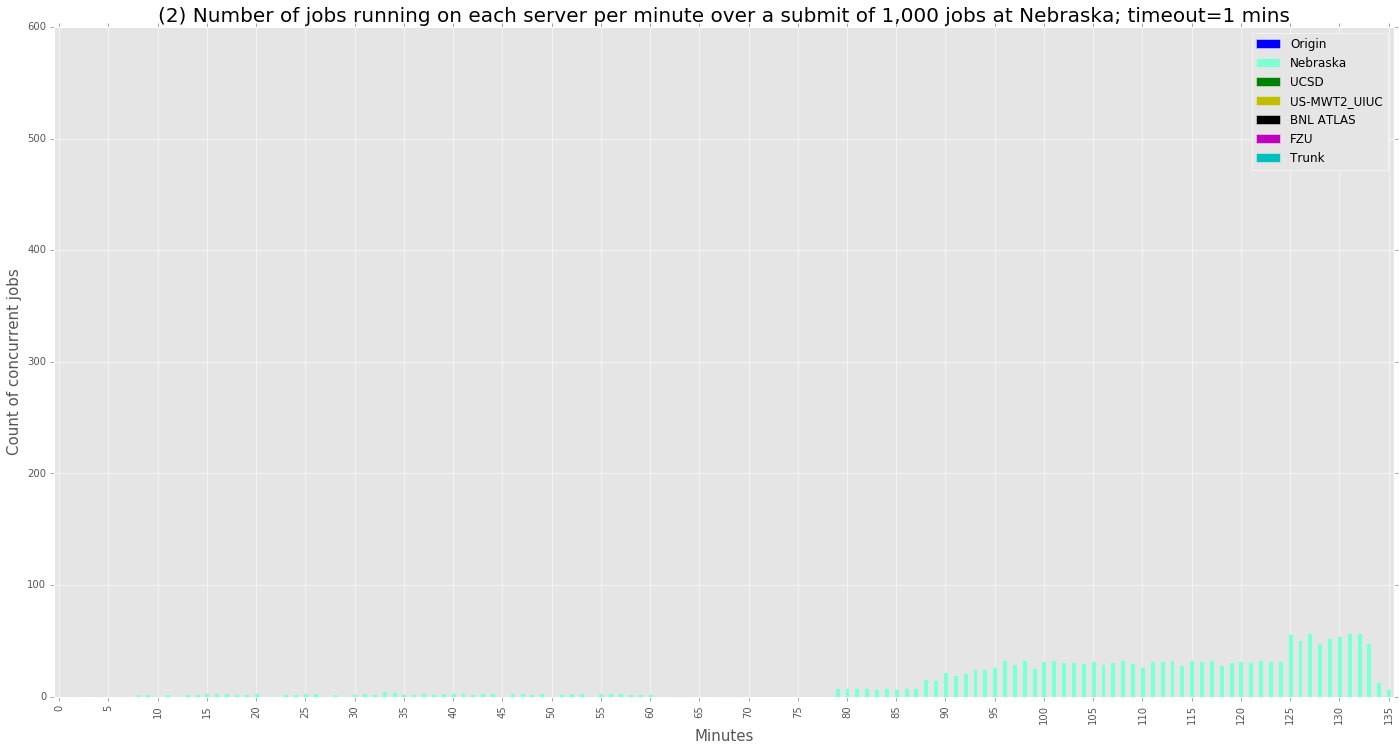

In [35]:
df2.plot.bar(stacked=True,figsize=[24, 12],color=['b', '#7FFFD4', 'g', 'y', 'k', 'm', 'c'])
plt.title('(2) Number of jobs running on each server per minute over a submit of 1,000 jobs at Nebraska; timeout=1 mins', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of concurrent jobs',fontsize=15)
#plt.text(90,95,'*No GLIDEIN_ResourceName specified in condor.submit')

plt.ylim([0,600])
plt.xticks(np.arange(0, length2+1, 5),np.arange(0, length2+1, 5))

plt.savefig('nebraska_concurrent_1min.png')
plt.show()


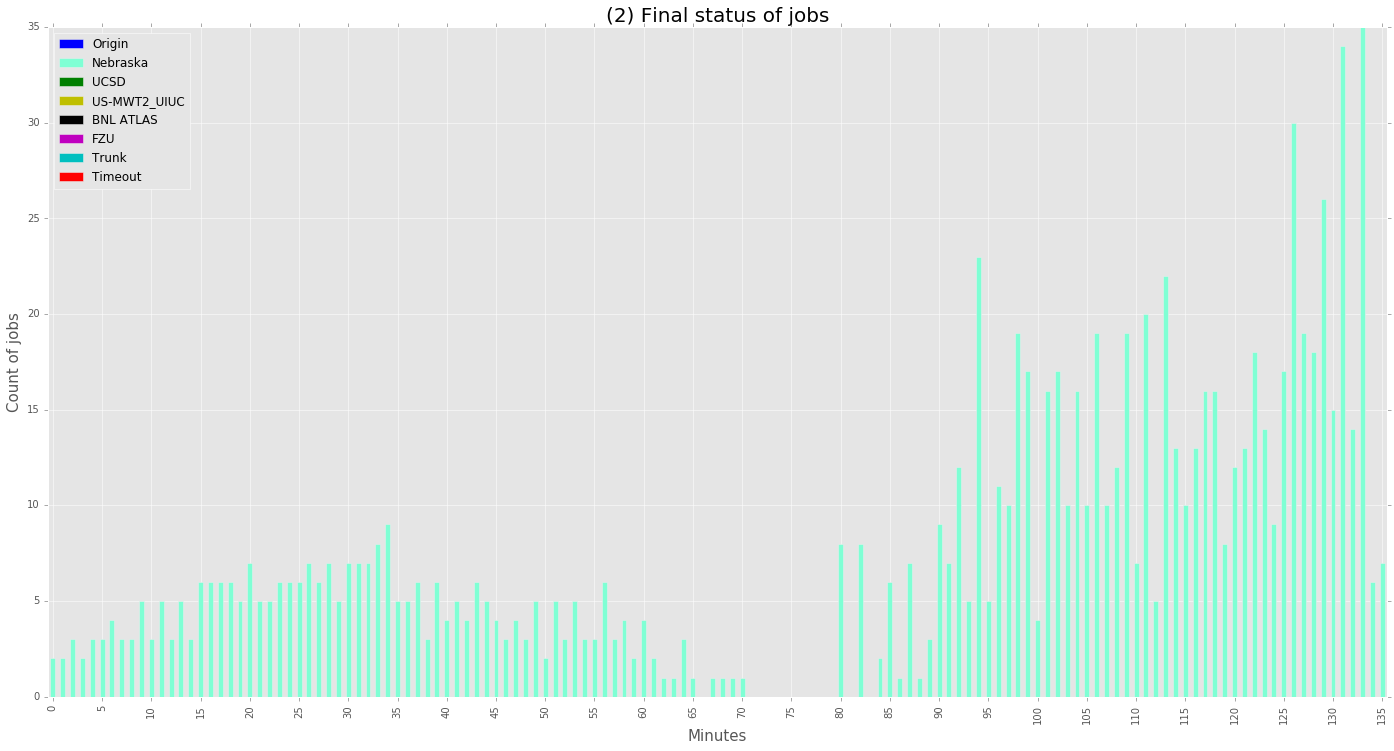

In [36]:
finish.plot.bar(stacked=True,figsize=[24, 12],color=['b', '#7FFFD4', 'g', 'y', 'k', 'm', 'c', 'r'])
plt.title('(2) Final status of jobs', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of jobs',fontsize=15)
plt.xticks(np.arange(0, length2+1, 5),np.arange(0, length2+1, 5))

plt.savefig('nebraska_finish_1min.png')


plt.show()


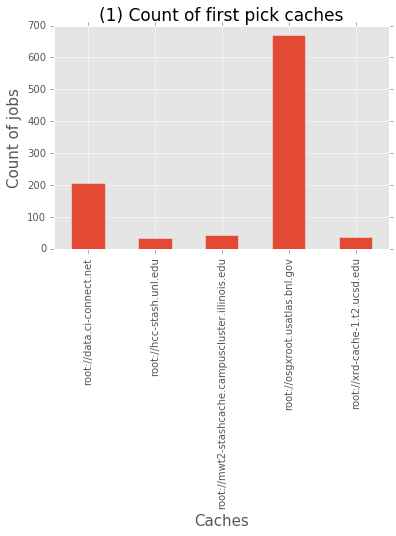

In [23]:
caches=df.groupby(['cache'])['cache'].count()
caches.plot.bar()
plt.title('(1) Count of first pick caches', fontsize=17) 
plt.xlabel('Caches', fontsize=15)
plt.ylabel('Count of jobs',fontsize=15)
plt.show()

In [12]:
df2.to_json('undirected.json')
finish.to_json('undirected_finish.json')

In [ ]:

download_time=[]
for i in range(length):
    if df['tries'].iloc[j]=="3":
        download_time.append(df2['download_time'].iloc[i])
print(download_time)